Copyright 2024 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title License
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Imports

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

import gin
gin.enter_interactive_mode()

import pandas as pd
import numpy as np

from eq_mag_prediction.seismology import earthquake_properties, strain_fields

2024-07-17 12:33:03.085038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# PLOTTING RESULTS

Define requesteds coordinates for plotting

In [ ]:
coors = np.array(np.meshgrid(np.linspace(-20, 20, 100), np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)))
coors.shape

(3, 100, 100, 100)

Define earthquaked properties

strike_range = (0, 360)

rake_range = (-90, 90)

dip_range = (0, 180)

In [ ]:
magnitude = 9.0

strike = np.deg2rad(20)
rake = np.deg2rad(0)
dip = np.deg2rad(90)

fault_angles = (strike, rake, dip)
fault_normal, strike_vector, slip_vector = earthquake_properties.moment_vectors_from_angles(strike, rake, dip)


print(f'fault_normal:\n {fault_normal}\n')
print(f'slip_vector:\n {slip_vector}\n')
print(f'strike_vector:\n {strike_vector}\n')

fault_normal:
 [ 3.42020143e-01  9.39692621e-01 -6.12323400e-17]

slip_vector:
 [ 0.93969262 -0.34202014  0.        ]

strike_vector:
 [ 0.93969262 -0.34202014  0.        ]



Create strain solution rotated to the NED coordinate system

In [ ]:
strain_tensor = earthquake_properties.strain_solution_rotated_to_ned(strike, rake, dip, magnitude, coors)
strain_tensor.shape

(3, 3, 100, 100, 100)

Create strain solution rotated **and transformed coordinates** to the NED coordinate system

In [ ]:
strain_tensor_in_ned = earthquake_properties.double_couple_strain_tensor_in_ned(strike, rake, dip, magnitude, coors)
strain_tensor_in_ned.shape

(3, 3, 100, 100, 100)

## Visualize the strain solutions and the fault plane

### Display a heamap of a single slice of a tensor element

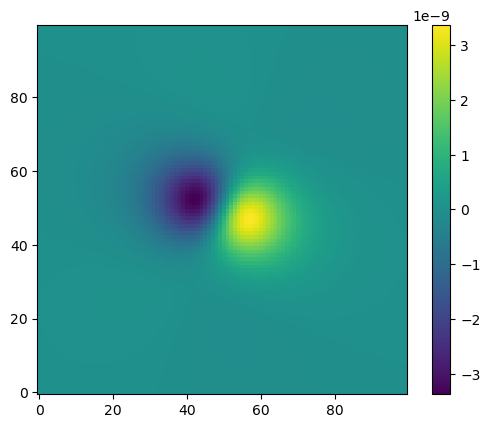

In [ ]:
plt.imshow(strain_tensor[0,0][:,:,30], origin='lower')
plt.colorbar()

### Display the solution roteted to NED coordinate system
The following plots are available in 'visualizations.py' with the installation of ```plotly``` and ```cartopy```.

See comment in last cell.

In [ ]:
u_ij=strain_tensor[0,0]
display_value=1e-10
value_region=1e-11
marker_opacity=0.01

to_show_logical_positive = ((display_value - value_region) <= u_ij) & (
    u_ij <= (display_value + value_region)
)
to_show_logical_negative = ((display_value - value_region) <= -u_ij) & (
    -u_ij <= (display_value + value_region)
)
coors_selected_4_scatter_positive = []
coors_selected_4_scatter_negative = []
for c in coors:
    coors_selected_4_scatter_positive.append(c[to_show_logical_positive])
    coors_selected_4_scatter_negative.append(c[to_show_logical_negative])


In [ ]:
min_x = coors[0].min()
max_x = coors[0].max()
min_y = coors[1].min()
max_y = coors[1].max()
coors_x1x2x3 = np.meshgrid(
    np.linspace(min_x, max_x, 30), np.linspace(min_y, max_y, 30), 0
)
coors_on_xy_plane = np.array(coors_x1x2x3).reshape((3, -1))
_, _, dip = fault_angles
_, strike_vector, _ = earthquake_properties.moment_vectors_from_angles(
    *fault_angles
)
plane_rotation = earthquake_properties.e3_to_fault_normal_rotation(
    dip, strike_vector
)
coors_on_plane = np.matmul(plane_rotation, coors_on_xy_plane)

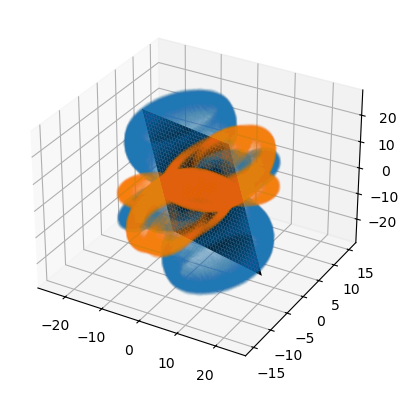

In [ ]:
# ---- The following plots are available in 'visualizations.py' with the installation of ```plotly``` and ```cartopy```. -----

#----- Plot using pyplot:
# ---------------------------------------------------------

X = coors_on_plane[0].reshape(coors_x1x2x3[0].shape)
Y = coors_on_plane[1].reshape(coors_x1x2x3[1].shape)
Z = coors_on_plane[2].reshape(coors_x1x2x3[2].shape)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(
    coors_selected_4_scatter_positive[0],
    coors_selected_4_scatter_positive[1],
    coors_selected_4_scatter_positive[2],
    alpha=0.03
)
ax.scatter(
    coors_selected_4_scatter_negative[0],
    coors_selected_4_scatter_negative[1],
    coors_selected_4_scatter_negative[2],
    alpha=0.03
)
ax.plot_surface(
    X.squeeze(),
    Y.squeeze(),
    Z.squeeze(),
    color='k',
)



#----- Plot using plotly and cartopy:
# ---------------------------------------------------------

# fig_tensor_rotated = visualizations.plot_strain_element(
#   strain_tensor[0,0],
#   coors,
#   display_value=1e-10, value_region=1e-11,
#   marker_opacity=0.01,
#   fault_angles=fault_angles,
#   layout={'width':700, 'height':700,})
# fig_tensor_rotated.show()


#--- Display the solution roteted **and converted** to NED coordinate system
# fig_tensor_converted = visualizations.plot_strain_element(
#   strain_tensor_in_ned[0,0],
#   coors,
#   display_value=1e-10, value_region=1e-11,
#   marker_opacity=0.05,
#   fault_angles=fault_angles,
#   layout={'width':700, 'height':700,})
# fig_tensor_converted.show()